In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
import keras_tuner as kt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Image Preprocessing

In [ ]:
dest_dir = "D:\Karet-1\Miranda\classifier dataset fix splitted merged"
train_dir = os.path.join(dest_dir, "train")
val_dir = os.path.join(dest_dir, "val")
test_dir = os.path.join(dest_dir, "test")

In [ ]:
img_width, img_height = 224,224

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')


val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 1303 images belonging to 5 classes.
Found 163 images belonging to 5 classes.


Found 163 images belonging to 5 classes.


# Building Model

In [ ]:
import sys
sys.path.append('D:\Karet-1\Miranda\ResNeSt-Tensorflow2-main')

In [ ]:
import resnest

base_model50 = resnest.resnest50(input_shape = (224,224, 3), include_top = False, weights = "imagenet")

In [ ]:
base_model50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 112, 112, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

In [ ]:
total_params = sum(tf.keras.backend.count_params(w) for w in base_model50.trainable_weights + base_model50.non_trainable_weights)

# Count the number of trainable parameters
trainable_params = sum(tf.keras.backend.count_params(w) for w in base_model50.trainable_weights)

# Calculate the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Total parameters: 25498816
Trainable parameters: 25434240
Non-trainable parameters: 64576


In [ ]:
len(base_model50.layers)

442

In [ ]:
# Freeze all layers
for layer in base_model50.layers:
  layer.trainable = False

In [ ]:
total_params = sum(tf.keras.backend.count_params(w) for w in base_model50.trainable_weights + base_model50.non_trainable_weights)

# Count the number of trainable parameters
trainable_params = sum(tf.keras.backend.count_params(w) for w in base_model50.trainable_weights)

# Calculate the number of non-trainable parameters
non_trainable_params = total_params - trainable_params

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Total parameters: 25498816
Trainable parameters: 0
Non-trainable parameters: 25498816


In [ ]:
base_model50.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'stage4_block3_shorcut_act')>

# Training

In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dense1 = tf.keras.layers.Dense(128, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.5)(dense1)
#reg1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(64, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
#reg2 = tf.keras.layers.BatchNormalization()(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model3 = tf.keras.Model(base_model.input, prediction)

In [ ]:
loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model3.compile(loss = loss, optimizer = opt, metrics = metric)

In [ ]:
history = model3.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
41/41 [==============================] - 18s 179ms/step - loss: 1.6859 - categorical_accuracy: 0.3051 - precision_3: 0.3533 - recall_3: 0.1499 - val_loss: 1.1438 - val_categorical_accuracy: 0.5305 - val_precision_3: 0.8021 - val_recall_3: 0.2348
Epoch 2/100
41/41 [==============================] - 4s 103ms/step - loss: 1.2420 - categorical_accuracy: 0.4727 - precision_3: 0.5996 - recall_3: 0.2567 - val_loss: 0.9689 - val_categorical_accuracy: 0.5854 - val_precision_3: 0.7984 - val_recall_3: 0.3140
Epoch 3/100
41/41 [==============================] - 4s 100ms/step - loss: 1.1376 - categorical_accuracy: 0.5135 - precision_3: 0.5879 - recall_3: 0.3136 - val_loss: 0.8845 - val_categorical_accuracy: 0.6311 - val_precision_3: 0.7811 - val_recall_3: 0.4024
Epoch 4/100
41/41 [==============================] - 4s 101ms/step - loss: 1.0404 - categorical_accuracy: 0.5511 - precision_3: 0.6403 - recall_3: 0.3912 - val_loss: 0.8355 - val_categorical_accuracy: 0.6341 - val_precision_3: 0

In [ ]:
with open('model2_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

model2.save("model2.h5")

# Necessary Evaluation Functions

In [ ]:
def acc_loss_plot(history):
  # Determine the limit of y-axis on the plot
  if hasattr(history, 'history'): # to check whether history is a History object from Keras or just a dictionary
    acc_min = min(min(history.history['categorical_accuracy']), min(history.history['val_categorical_accuracy']))
    acc_max = max(max(history.history['categorical_accuracy']), max(history.history['val_categorical_accuracy']))
    loss_min = min(min(history.history['loss']), min(history.history['val_loss']))
    loss_max = max(max(history.history['loss']), max(history.history['val_loss']))
  else:
    acc_min = min(min(history['categorical_accuracy']), min(history['val_categorical_accuracy']))
    acc_max = max(max(history['categorical_accuracy']), max(history['val_categorical_accuracy']))
    loss_min = min(min(history['loss']), min(history['val_loss']))
    loss_max = max(max(history['loss']), max(history['val_loss']))

  # batas dibulatkan ke 0.01 terdekat
  acc_min = round(acc_min - 0.1, 1)
  acc_max = round(acc_max + 0.1, 1)
  loss_min = round(loss_min - 0.1, 1)
  loss_max = round(loss_max + 0.1, 1)

  # plotting accuracy dan loss
  if hasattr(history, 'history'):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.yticks([i / 10 for i in range(int(acc_min * 10), int(acc_max * 10) + 1, 1)])  # Set y-axis ticks with 0.1 difference
    plt.grid(True)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.yticks([i / 10 for i in range(int(loss_min * 10), int(loss_max * 10) + 1, 1)])  # Set y-axis ticks with 0.1 difference
    plt.grid(True)
    plt.show()
  else:
    plt.plot(history['categorical_accuracy'])
    plt.plot(history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.yticks([i / 10 for i in range(int(acc_min * 10), int(acc_max * 10) + 1, 1)])  # Set y-axis ticks with 0.1 difference
    plt.grid(True)
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.yticks([i / 10 for i in range(int(loss_min * 10), int(loss_max * 10) + 1, 1)])  # Set y-axis ticks with 0.1 difference
    plt.grid(True)
    plt.show()

In [ ]:
def metrics_table(history):
  from tabulate import tabulate
  if hasattr(history, 'history'):
    last_epoch = len(history.history['categorical_accuracy']) - 1
  else:
    last_epoch = len(history['categorical_accuracy']) - 1

  # take best accuracy and best loss
  if hasattr(history, 'history'):
    best_train_accuracy = max(history.history['categorical_accuracy'])
    best_train_loss = min(history.history['loss'])
    best_val_accuracy = max(history.history['val_categorical_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    last_train_accuracy = history.history['categorical_accuracy'][last_epoch]
    last_train_loss = history.history['loss'][last_epoch]
    last_val_accuracy = history.history['val_categorical_accuracy'][last_epoch]
    last_val_loss = history.history['val_loss'][last_epoch]
  else:
    best_train_accuracy = max(history['categorical_accuracy'])
    best_train_loss = min(history['loss'])
    best_val_accuracy = max(history['val_categorical_accuracy'])
    best_val_loss = min(history['val_loss'])
    last_train_accuracy = history['categorical_accuracy'][last_epoch]
    last_train_loss = history['loss'][last_epoch]
    last_val_accuracy = history['val_categorical_accuracy'][last_epoch]
    last_val_loss = history['val_loss'][last_epoch]

  # Define the table
  data_best = [
      ["Accuracy", f"{best_train_accuracy}", f"{best_val_accuracy}"],
      ["Loss", f"{best_train_loss}", f"{best_val_loss}"]]
  data_last = [
      ["Accuracy", f"{last_train_accuracy}", f"{last_val_accuracy}"],
      ["Loss", f"{last_train_loss}", f"{last_val_loss}"]]
  headers = ["Metrics", "Train", "Val"]

  # Print the table
  print("Best Metrics")
  print(tabulate(data_best, headers=headers, tablefmt="grid"))
  print("\nLast Metrics")
  print(tabulate(data_last, headers=headers, tablefmt="grid"))

# Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model3(hp, base_model):
    flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    dense1 = tf.keras.layers.Dense(hp.Choice('units1', [32, 64, 128, 512, 1024]), activation='relu')(flatten)
    dropout1 = tf.keras.layers.Dropout(hp.Choice('dropout_rate1', [0.1, 0.2, 0.3, 0.4, 0.5]))(dense1)
    use_dense2 = hp.Boolean('use_dense2')
    if use_dense2:
        dense2 = tf.keras.layers.Dense(hp.Choice('units2', [32, 64, 128, 512, 1024]), activation='relu')(dropout1)
        dropout2 = tf.keras.layers.Dropout(hp.Choice('dropout_rate2', [0.1, 0.2, 0.3, 0.4, 0.5]))(dense2)
        last_layer = dropout2
    else:
        last_layer = dropout1
    prediction = tf.keras.layers.Dense(5, activation='softmax', name='prediction')(last_layer)
    model = tf.keras.Model(inputs=base_model.input, outputs=prediction)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    loss = tf.keras.losses.categorical_crossentropy
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    metric = [tf.keras.metrics.CategoricalAccuracy()]
    model.compile(loss=loss, optimizer=opt, metrics=metric)
    return model


In [ ]:
tuner = kt.GridSearch(
    hypermodel=lambda hp: build_model3(hp, base_model50),
    objective="val_loss",
    max_trials=200,
    directory="D:\Karet-1\Miranda\hyperparameter_tuning_new_2",
    project_name= 'hyperparameter_resnest_1'
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 512, 1024], 'ordered': True}
dropout_rate1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
use_dense2 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [ ]:
tuner.search(train_generator, epochs=100, validation_data=val_generator)

Trial 200 Complete [00h 08m 20s]
val_loss: 1.2139884233474731

Best val_loss So Far: 0.47692304849624634
Total elapsed time: 1d 00h 25m 42s


In [ ]:
# summary of search result
tuner.results_summary()

Results summary
Results in D:\Karet-1\Miranda\hyperparameter_tuning_new_2\hyperparameter_resnest_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 004 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.1
use_dense2: True
learning_rate: 0.001
units2: 32
dropout_rate2: 0.1
Score: 0.47692304849624634

Trial 034 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.1
use_dense2: True
learning_rate: 0.0001
units2: 64
dropout_rate2: 0.1
Score: 0.48183566331863403

Trial 110 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.2
use_dense2: False
learning_rate: 0.001
units2: 64
dropout_rate2: 0.2
Score: 0.48565953969955444

Trial 036 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.1
use_dense2: True
learning_rate: 0.0001
units2: 64
dropout_rate2: 0.3
Score: 0.485902339220047

Trial 032 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.1
use_dense2: True
learning_rate: 0.0001
units2: 32
dropout_rate2: 0.4
Score: 0.49105581641197205

Trial 033 summary
Hyperpar

##  Retrain to check each best hps


### 1st best hps

In [ ]:
# model is retrained using the best hps, one by one
# 'best_hps[0]' is changed into 1,2,..,9 to get each best hps
best_hps = tuner.get_best_hyperparameters(10)
model11 = build_model3(best_hps[0], base_model50)

history11 = model11.fit(train_generator, epochs=150, validation_data=test_generator)

Epoch 1/150
41/41 [==============================] - 9s 110ms/step - loss: 1.2189 - categorical_accuracy: 0.4728 - val_loss: 0.7805 - val_categorical_accuracy: 0.6748
Epoch 2/150
41/41 [==============================] - 3s 72ms/step - loss: 0.8042 - categorical_accuracy: 0.6546 - val_loss: 0.6418 - val_categorical_accuracy: 0.6994
Epoch 3/150
41/41 [==============================] - 3s 76ms/step - loss: 0.7093 - categorical_accuracy: 0.6853 - val_loss: 0.5844 - val_categorical_accuracy: 0.7791
Epoch 4/150
41/41 [==============================] - 3s 71ms/step - loss: 0.6209 - categorical_accuracy: 0.7283 - val_loss: 0.5567 - val_categorical_accuracy: 0.7853
Epoch 5/150
41/41 [==============================] - 3s 76ms/step - loss: 0.5711 - categorical_accuracy: 0.7467 - val_loss: 0.5310 - val_categorical_accuracy: 0.8037
Epoch 6/150
41/41 [==============================] - 3s 72ms/step - loss: 0.5444 - categorical_accuracy: 0.7744 - val_loss: 0.5141 - val_categorical_accuracy: 0.7791
Epo

Best Metrics
+-----------+------------+----------+
| Metrics   |      Train |      Val |
+===========+============+==========+
| Accuracy  | 0.998465   | 0.809816 |
+-----------+------------+----------+
| Loss      | 0.00721349 | 0.478272 |
+-----------+------------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.99386  | 0.748466 |
+-----------+----------+----------+
| Loss      | 0.017968 | 1.79954  |
+-----------+----------+----------+


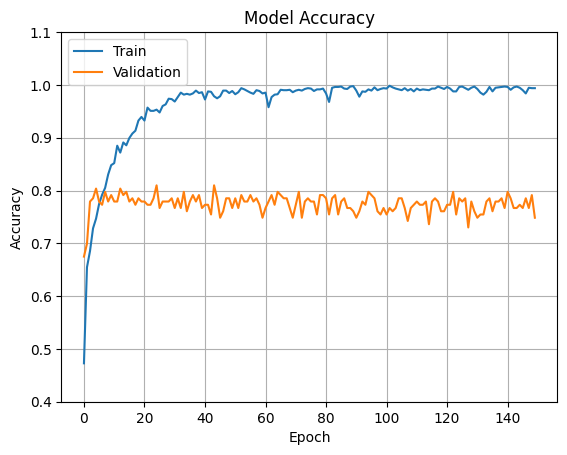

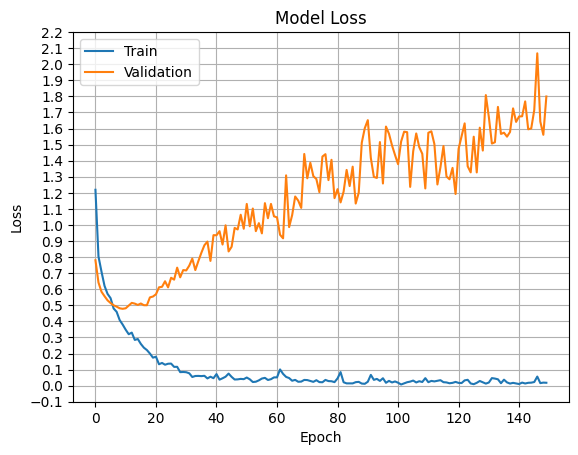

In [ ]:
metrics_table(history11)
acc_loss_plot(history11)

### 2nd best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(5)
model12 = build_model3(best_hps[1], base_model50)

# fit the dataset
history12 = model12.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 9s 113ms/step - loss: 1.4366 - categorical_accuracy: 0.3776 - val_loss: 1.2221 - val_categorical_accuracy: 0.5215
Epoch 2/150
41/41 [==============================] - 3s 75ms/step - loss: 1.1507 - categorical_accuracy: 0.5288 - val_loss: 0.9809 - val_categorical_accuracy: 0.6258
Epoch 3/150
41/41 [==============================] - 3s 81ms/step - loss: 0.9816 - categorical_accuracy: 0.5925 - val_loss: 0.8540 - val_categorical_accuracy: 0.6994
Epoch 4/150
41/41 [==============================] - 3s 75ms/step - loss: 0.8994 - categorical_accuracy: 0.6224 - val_loss: 0.7835 - val_categorical_accuracy: 0.6994
Epoch 5/150
41/41 [==============================] - 3s 76ms/step - loss: 0.8349 - categorical_accuracy: 0.6546 - val_loss: 0.7310 - val_categorical_accuracy: 0.7485
Epoch 6/150
41/41 [==============================] - 3s 78ms/step - loss: 0.8004 - categorical_accuracy: 0.6546 - val_loss: 0.6995 - val_categorical_accuracy: 0.7607
Epo

Best Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.997698  | 0.815951 |
+-----------+-----------+----------+
| Loss      | 0.0190954 | 0.473741 |
+-----------+-----------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.993093  | 0.791411 |
+-----------+-----------+----------+
| Loss      | 0.0277891 | 0.872841 |
+-----------+-----------+----------+


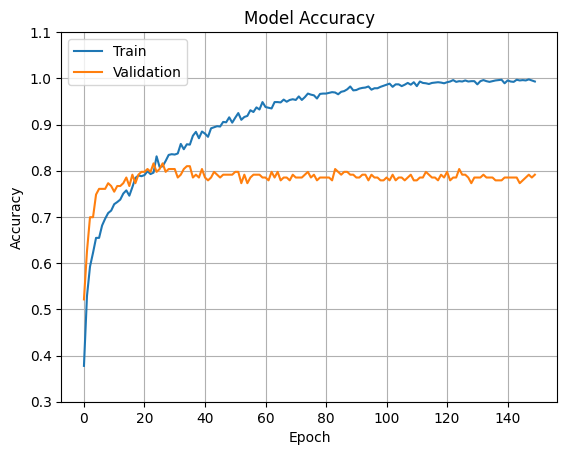

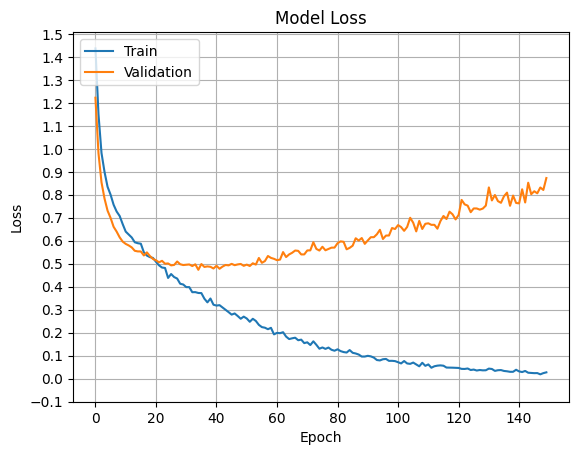

In [ ]:
metrics_table(history12)
acc_loss_plot(history12)

### 3rd best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(5)
model13 = build_model3(best_hps[2], base_model50)

# fit the dataset
history13 = model13.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 121ms/step - loss: 1.0244 - categorical_accuracy: 0.5741 - val_loss: 0.6796 - val_categorical_accuracy: 0.7730
Epoch 2/150
41/41 [==============================] - 3s 76ms/step - loss: 0.7330 - categorical_accuracy: 0.6953 - val_loss: 0.6152 - val_categorical_accuracy: 0.7546
Epoch 3/150
41/41 [==============================] - 3s 81ms/step - loss: 0.6360 - categorical_accuracy: 0.7337 - val_loss: 0.5786 - val_categorical_accuracy: 0.7423
Epoch 4/150
41/41 [==============================] - 3s 80ms/step - loss: 0.5903 - categorical_accuracy: 0.7475 - val_loss: 0.5574 - val_categorical_accuracy: 0.7853
Epoch 5/150
41/41 [==============================] - 3s 81ms/step - loss: 0.5260 - categorical_accuracy: 0.7866 - val_loss: 0.5441 - val_categorical_accuracy: 0.7853
Epoch 6/150
41/41 [==============================] - 3s 79ms/step - loss: 0.4996 - categorical_accuracy: 0.7828 - val_loss: 0.5677 - val_categorical_accuracy: 0.7853
Ep

Best Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.99386   | 0.815951 |
+-----------+-----------+----------+
| Loss      | 0.0181172 | 0.504409 |
+-----------+-----------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.986953  | 0.779141 |
+-----------+-----------+----------+
| Loss      | 0.0304103 | 1.57336  |
+-----------+-----------+----------+


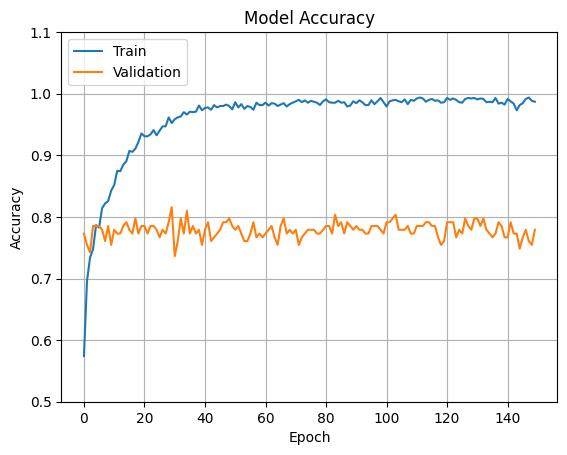

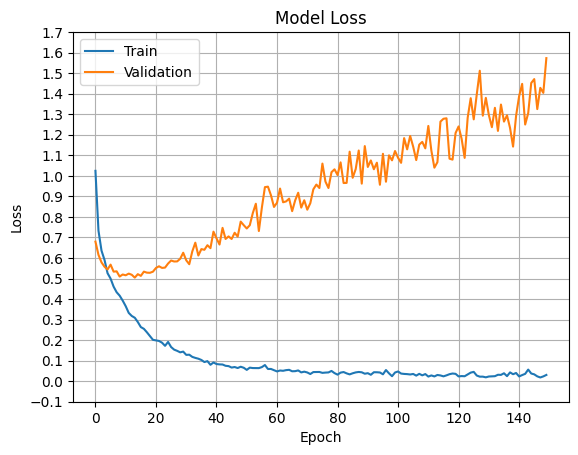

In [ ]:
metrics_table(history13)
acc_loss_plot(history13)

### 4th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(5)
model14 = build_model3(best_hps[3], base_model50)

# fit the dataset
history14 = model14.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 9s 116ms/step - loss: 1.6303 - categorical_accuracy: 0.2433 - val_loss: 1.4691 - val_categorical_accuracy: 0.3620
Epoch 2/150
41/41 [==============================] - 3s 76ms/step - loss: 1.4149 - categorical_accuracy: 0.3876 - val_loss: 1.2904 - val_categorical_accuracy: 0.4847
Epoch 3/150
41/41 [==============================] - 3s 78ms/step - loss: 1.2845 - categorical_accuracy: 0.4697 - val_loss: 1.1211 - val_categorical_accuracy: 0.6196
Epoch 4/150
41/41 [==============================] - 3s 77ms/step - loss: 1.1688 - categorical_accuracy: 0.5388 - val_loss: 0.9939 - val_categorical_accuracy: 0.6442
Epoch 5/150
41/41 [==============================] - 3s 78ms/step - loss: 1.0383 - categorical_accuracy: 0.5925 - val_loss: 0.8793 - val_categorical_accuracy: 0.7239
Epoch 6/150
41/41 [==============================] - 3s 79ms/step - loss: 0.9764 - categorical_accuracy: 0.6140 - val_loss: 0.8110 - val_categorical_accuracy: 0.7117
Epo

Best Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.996163  | 0.828221 |
+-----------+-----------+----------+
| Loss      | 0.0337141 | 0.480983 |
+-----------+-----------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.996163  | 0.803681 |
+-----------+-----------+----------+
| Loss      | 0.0337141 | 0.767898 |
+-----------+-----------+----------+


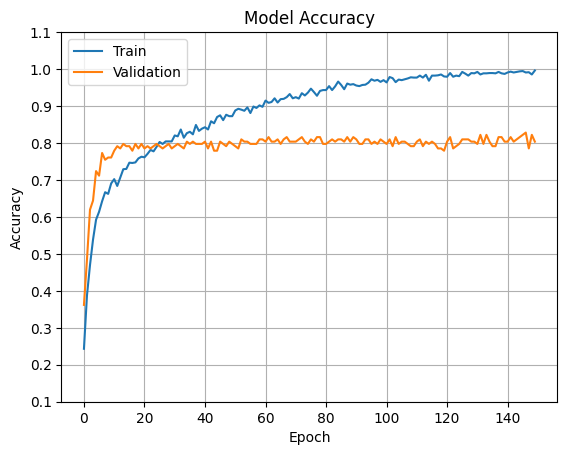

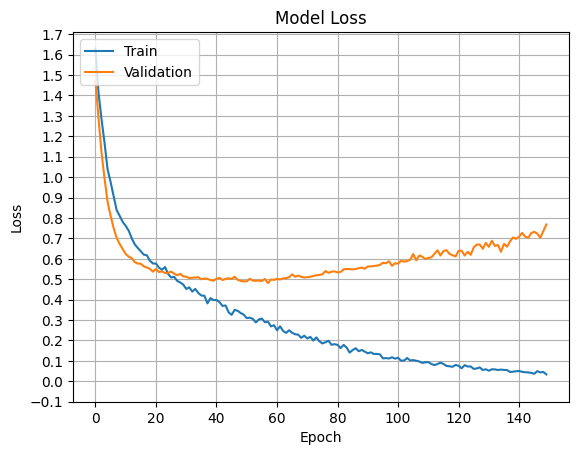

In [ ]:
metrics_table(history14)
acc_loss_plot(history14)

### 5th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(5)
model15 = build_model3(best_hps[4], base_model50)

# fit the dataset
history15 = model15.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 116ms/step - loss: 1.7020 - categorical_accuracy: 0.2356 - val_loss: 1.3972 - val_categorical_accuracy: 0.3620
Epoch 2/150
41/41 [==============================] - 3s 79ms/step - loss: 1.4092 - categorical_accuracy: 0.3239 - val_loss: 1.2483 - val_categorical_accuracy: 0.3988
Epoch 3/150
41/41 [==============================] - 3s 76ms/step - loss: 1.3133 - categorical_accuracy: 0.3906 - val_loss: 1.1659 - val_categorical_accuracy: 0.4479
Epoch 4/150
41/41 [==============================] - 3s 76ms/step - loss: 1.2490 - categorical_accuracy: 0.4328 - val_loss: 1.0955 - val_categorical_accuracy: 0.6258
Epoch 5/150
41/41 [==============================] - 3s 77ms/step - loss: 1.2001 - categorical_accuracy: 0.4705 - val_loss: 1.0272 - val_categorical_accuracy: 0.7055
Epoch 6/150
41/41 [==============================] - 3s 79ms/step - loss: 1.1338 - categorical_accuracy: 0.5065 - val_loss: 0.9840 - val_categorical_accuracy: 0.6871
Ep

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.973906 | 0.822086 |
+-----------+----------+----------+
| Loss      | 0.132041 | 0.471845 |
+-----------+----------+----------+

Last Metrics
+-----------+---------+----------+
| Metrics   |   Train |      Val |
+===========+=========+==========+
| Accuracy  | 0.95779 | 0.779141 |
+-----------+---------+----------+
| Loss      | 0.1336  | 0.621062 |
+-----------+---------+----------+


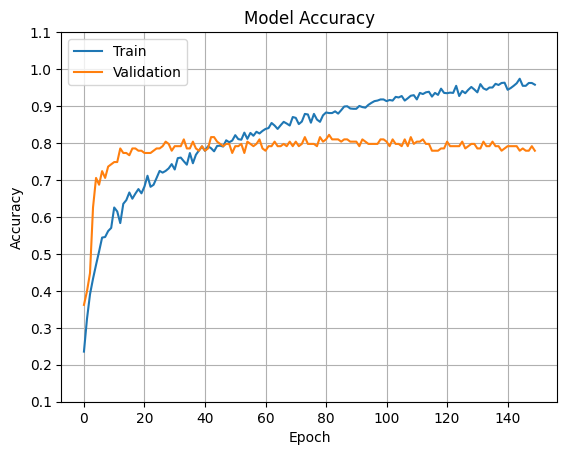

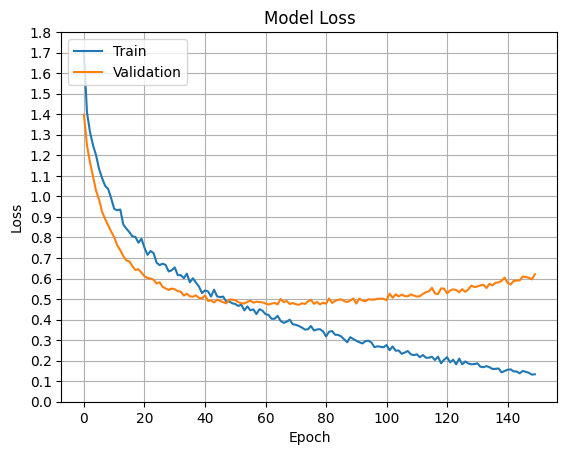

In [ ]:
metrics_table(history15)
acc_loss_plot(history15)

### 6th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(11)
model16 = build_model3(best_hps[5], base_model50)

# fit the dataset
history16 = model16.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 119ms/step - loss: 1.7467 - categorical_accuracy: 0.2387 - val_loss: 1.4449 - val_categorical_accuracy: 0.4417
Epoch 2/150
41/41 [==============================] - 3s 75ms/step - loss: 1.4806 - categorical_accuracy: 0.3216 - val_loss: 1.2904 - val_categorical_accuracy: 0.5583
Epoch 3/150
41/41 [==============================] - 3s 81ms/step - loss: 1.3856 - categorical_accuracy: 0.4114 - val_loss: 1.1740 - val_categorical_accuracy: 0.5890
Epoch 4/150
41/41 [==============================] - 3s 80ms/step - loss: 1.2978 - categorical_accuracy: 0.4444 - val_loss: 1.0616 - val_categorical_accuracy: 0.6687
Epoch 5/150
41/41 [==============================] - 3s 76ms/step - loss: 1.1807 - categorical_accuracy: 0.5096 - val_loss: 0.9606 - val_categorical_accuracy: 0.7485
Epoch 6/150
41/41 [==============================] - 3s 78ms/step - loss: 1.1169 - categorical_accuracy: 0.5211 - val_loss: 0.9034 - val_categorical_accuracy: 0.7423
Ep

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.957022 | 0.822086 |
+-----------+----------+----------+
| Loss      | 0.167016 | 0.469605 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.94551  | 0.815951 |
+-----------+----------+----------+
| Loss      | 0.167219 | 0.558367 |
+-----------+----------+----------+


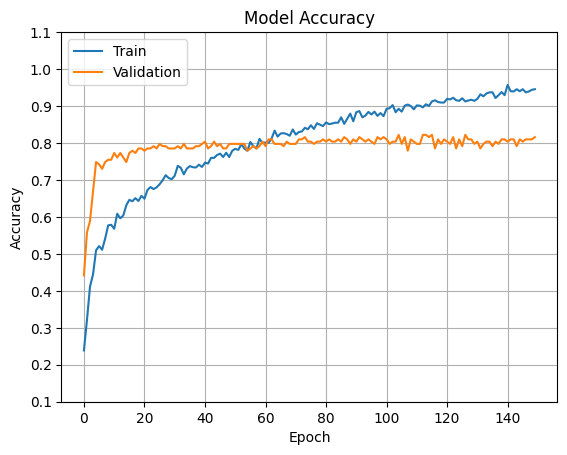

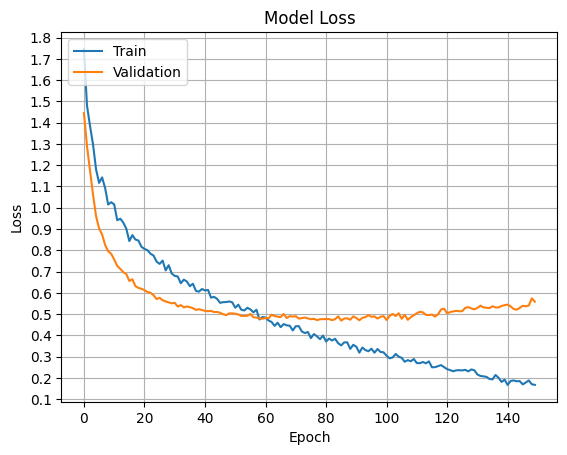

In [ ]:
metrics_table(history16)
acc_loss_plot(history16)

### 7th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(11)
model17 = build_model3(best_hps[6], base_model50)

# fit the dataset
history17 = model17.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 11s 117ms/step - loss: 1.0089 - categorical_accuracy: 0.5610 - val_loss: 0.6793 - val_categorical_accuracy: 0.7055
Epoch 2/150
41/41 [==============================] - 3s 77ms/step - loss: 0.6383 - categorical_accuracy: 0.7168 - val_loss: 0.5687 - val_categorical_accuracy: 0.7853
Epoch 3/150
41/41 [==============================] - 3s 81ms/step - loss: 0.5469 - categorical_accuracy: 0.7475 - val_loss: 0.5245 - val_categorical_accuracy: 0.7853
Epoch 4/150
41/41 [==============================] - 3s 81ms/step - loss: 0.4923 - categorical_accuracy: 0.7820 - val_loss: 0.5692 - val_categorical_accuracy: 0.7423
Epoch 5/150
41/41 [==============================] - 3s 80ms/step - loss: 0.4293 - categorical_accuracy: 0.8081 - val_loss: 0.5226 - val_categorical_accuracy: 0.7546
Epoch 6/150
41/41 [==============================] - 3s 79ms/step - loss: 0.3830 - categorical_accuracy: 0.8396 - val_loss: 0.4807 - val_categorical_accuracy: 0.7791
Ep

Best Metrics
+-----------+------------+----------+
| Metrics   |      Train |      Val |
+===========+============+==========+
| Accuracy  | 0.999233   | 0.828221 |
+-----------+------------+----------+
| Loss      | 0.00411103 | 0.480678 |
+-----------+------------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.989256  | 0.791411 |
+-----------+-----------+----------+
| Loss      | 0.0287875 | 1.67727  |
+-----------+-----------+----------+


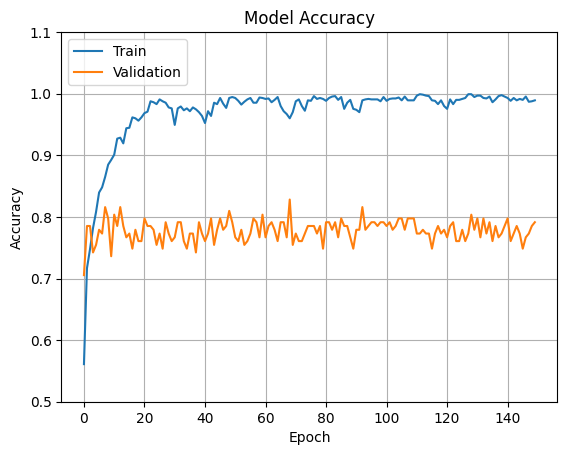

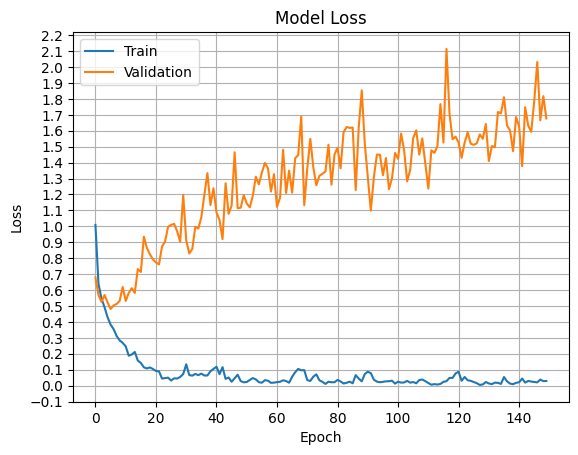

In [ ]:
metrics_table(history17)
acc_loss_plot(history17)

### 8th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(11)
model18 = build_model3(best_hps[7], base_model50)

# fit the dataset
history18 = model18.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 119ms/step - loss: 1.2035 - categorical_accuracy: 0.4774 - val_loss: 0.7475 - val_categorical_accuracy: 0.6994
Epoch 2/150
41/41 [==============================] - 3s 81ms/step - loss: 0.8303 - categorical_accuracy: 0.6370 - val_loss: 0.6211 - val_categorical_accuracy: 0.7914
Epoch 3/150
41/41 [==============================] - 3s 84ms/step - loss: 0.6881 - categorical_accuracy: 0.7084 - val_loss: 0.5427 - val_categorical_accuracy: 0.7914
Epoch 4/150
41/41 [==============================] - 3s 79ms/step - loss: 0.6182 - categorical_accuracy: 0.7306 - val_loss: 0.5580 - val_categorical_accuracy: 0.7485
Epoch 5/150
41/41 [==============================] - 3s 82ms/step - loss: 0.5706 - categorical_accuracy: 0.7621 - val_loss: 0.5235 - val_categorical_accuracy: 0.7853
Epoch 6/150
41/41 [==============================] - 3s 80ms/step - loss: 0.5186 - categorical_accuracy: 0.7790 - val_loss: 0.5311 - val_categorical_accuracy: 0.7546
Ep

Best Metrics
+-----------+------------+----------+
| Metrics   |      Train |      Val |
+===========+============+==========+
| Accuracy  | 0.998465   | 0.822086 |
+-----------+------------+----------+
| Loss      | 0.00705169 | 0.466597 |
+-----------+------------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.987721  | 0.785276 |
+-----------+-----------+----------+
| Loss      | 0.0413737 | 1.77207  |
+-----------+-----------+----------+


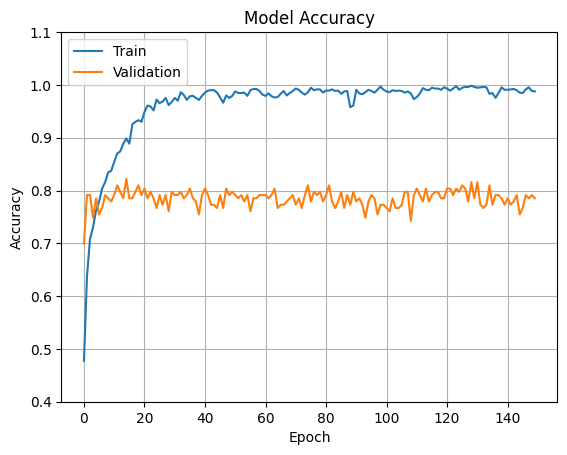

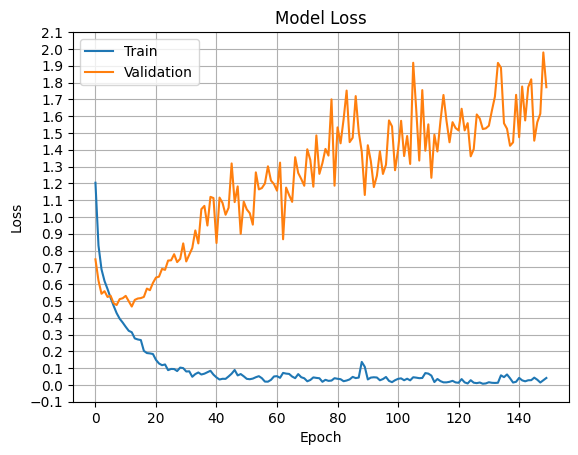

In [ ]:
metrics_table(history18)
acc_loss_plot(history18)

### 9th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(11)
model19 = build_model3(best_hps[8], base_model50)

# fit the dataset
history19 = model19.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 117ms/step - loss: 1.5134 - categorical_accuracy: 0.3308 - val_loss: 1.2189 - val_categorical_accuracy: 0.4908
Epoch 2/150
41/41 [==============================] - 3s 78ms/step - loss: 1.1430 - categorical_accuracy: 0.5303 - val_loss: 1.0066 - val_categorical_accuracy: 0.6135
Epoch 3/150
41/41 [==============================] - 3s 78ms/step - loss: 0.9968 - categorical_accuracy: 0.6117 - val_loss: 0.8737 - val_categorical_accuracy: 0.6687
Epoch 4/150
41/41 [==============================] - 3s 79ms/step - loss: 0.9011 - categorical_accuracy: 0.6178 - val_loss: 0.8009 - val_categorical_accuracy: 0.6933
Epoch 5/150
41/41 [==============================] - 3s 79ms/step - loss: 0.8431 - categorical_accuracy: 0.6493 - val_loss: 0.7561 - val_categorical_accuracy: 0.7055
Epoch 6/150
41/41 [==============================] - 3s 81ms/step - loss: 0.7753 - categorical_accuracy: 0.6899 - val_loss: 0.7166 - val_categorical_accuracy: 0.7178
Ep

Best Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.993093  | 0.815951 |
+-----------+-----------+----------+
| Loss      | 0.0701895 | 0.481744 |
+-----------+-----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.988488 | 0.773006 |
+-----------+----------+----------+
| Loss      | 0.071936 | 0.558601 |
+-----------+----------+----------+


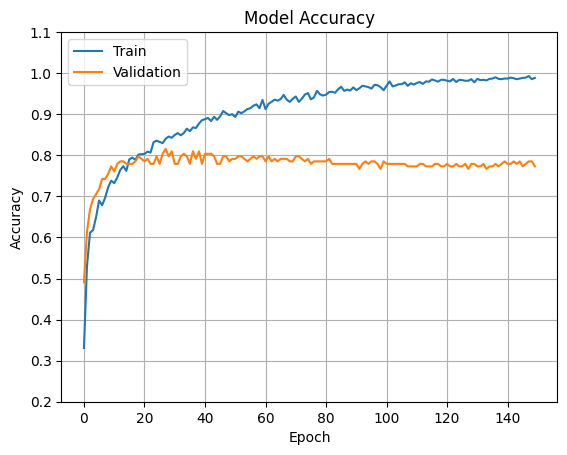

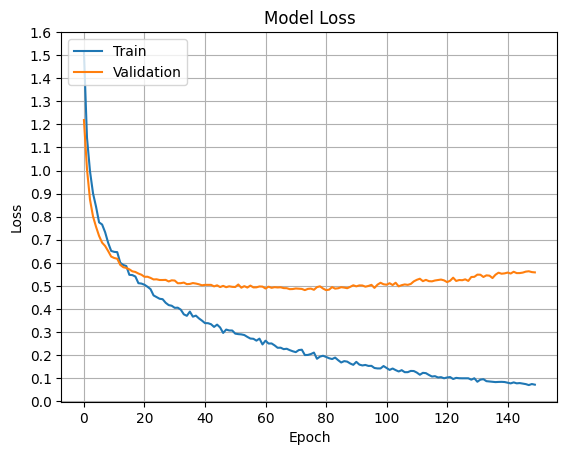

In [ ]:
metrics_table(history19)
acc_loss_plot(history19)

### 10th best hps

In [ ]:
# retrain the model
best_hps = tuner.get_best_hyperparameters(11)
model110 = build_model3(best_hps[9], base_model50)

# fit the dataset
history110 = model110.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 119ms/step - loss: 1.5452 - categorical_accuracy: 0.3116 - val_loss: 1.3254 - val_categorical_accuracy: 0.5031
Epoch 2/150
41/41 [==============================] - 3s 80ms/step - loss: 1.2843 - categorical_accuracy: 0.4712 - val_loss: 1.0867 - val_categorical_accuracy: 0.5644
Epoch 3/150
41/41 [==============================] - 3s 79ms/step - loss: 1.1233 - categorical_accuracy: 0.5602 - val_loss: 0.9660 - val_categorical_accuracy: 0.6626
Epoch 4/150
41/41 [==============================] - 3s 78ms/step - loss: 1.0225 - categorical_accuracy: 0.5986 - val_loss: 0.8659 - val_categorical_accuracy: 0.7117
Epoch 5/150
41/41 [==============================] - 3s 75ms/step - loss: 0.9414 - categorical_accuracy: 0.6431 - val_loss: 0.7995 - val_categorical_accuracy: 0.7546
Epoch 6/150
41/41 [==============================] - 3s 83ms/step - loss: 0.9009 - categorical_accuracy: 0.6362 - val_loss: 0.7566 - val_categorical_accuracy: 0.7669
Ep

Best Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.995395  | 0.815951 |
+-----------+-----------+----------+
| Loss      | 0.0383955 | 0.502761 |
+-----------+-----------+----------+

Last Metrics
+-----------+-----------+----------+
| Metrics   |     Train |      Val |
+===========+===========+==========+
| Accuracy  | 0.985418  | 0.809816 |
+-----------+-----------+----------+
| Loss      | 0.0514581 | 0.717181 |
+-----------+-----------+----------+


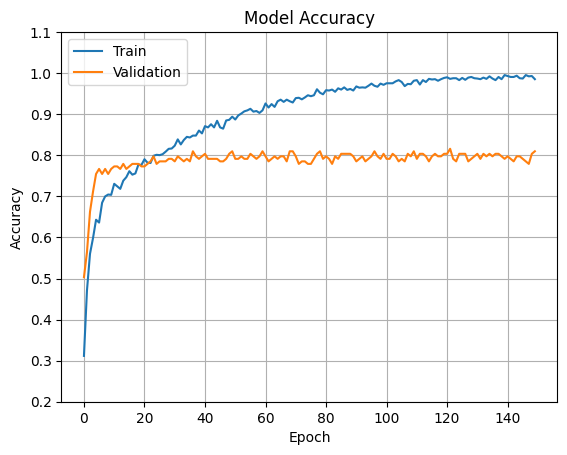

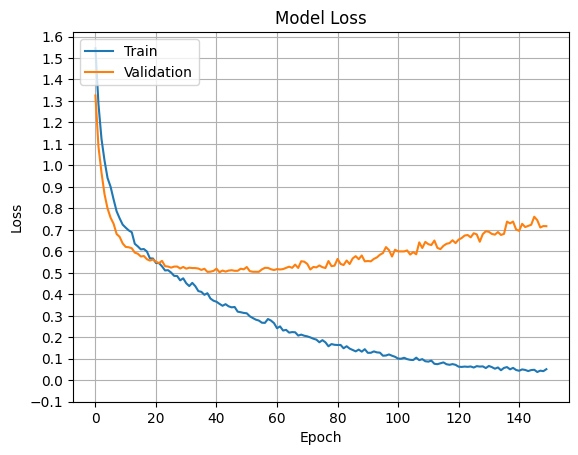

In [ ]:
metrics_table(history110)
acc_loss_plot(history110)

# Retrain model with the best hyperparameter (the 6th hyperparameter combination)

## retrain 1

In [ ]:
best_hps = tuner.get_best_hyperparameters(11)
best_hps[5].values

{'units1': 32,
 'dropout_rate1': 0.1,
 'use_dense2': True,
 'learning_rate': 0.0001,
 'units2': 32,
 'dropout_rate2': 0.5}

In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model50.output)
dense1 = tf.keras.layers.Dense(32, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model6_1 = tf.keras.Model(base_model50.input, prediction)

loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model6_1.compile(loss = loss, optimizer = opt, metrics = metric)

history6_1 = model6_1.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 10s 115ms/step - loss: 1.6604 - categorical_accuracy: 0.2709 - precision_1: 0.3443 - recall_1: 0.0560 - val_loss: 1.4347 - val_categorical_accuracy: 0.4540 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/150
41/41 [==============================] - 3s 70ms/step - loss: 1.4503 - categorical_accuracy: 0.3415 - precision_1: 0.6796 - recall_1: 0.0537 - val_loss: 1.3251 - val_categorical_accuracy: 0.5337 - val_precision_1: 1.0000 - val_recall_1: 0.0061
Epoch 3/150
41/41 [==============================] - 3s 74ms/step - loss: 1.3673 - categorical_accuracy: 0.4244 - precision_1: 0.7066 - recall_1: 0.0906 - val_loss: 1.2266 - val_categorical_accuracy: 0.5337 - val_precision_1: 0.8000 - val_recall_1: 0.0245
Epoch 4/150
41/41 [==============================] - 3s 73ms/step - loss: 1.2700 - categorical_accuracy: 0.4628 - precision_1: 0.6845 - recall_1: 0.1665 - val_loss: 1.1171 - val_categorical_accuracy: 0.5828 - val_precision

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.95779  | 0.828221 |
+-----------+----------+----------+
| Loss      | 0.147979 | 0.461217 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.94858  | 0.785276 |
+-----------+----------+----------+
| Loss      | 0.169183 | 0.558989 |
+-----------+----------+----------+


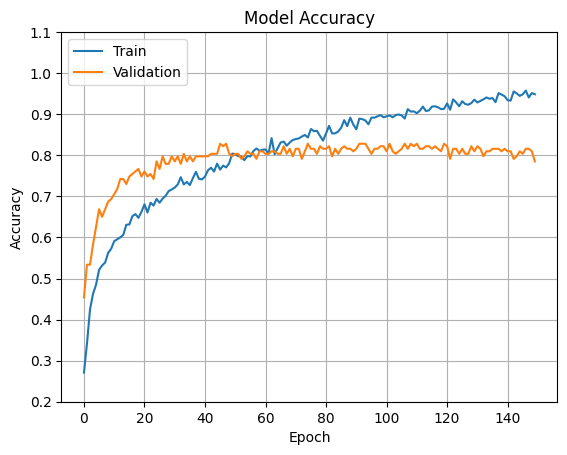

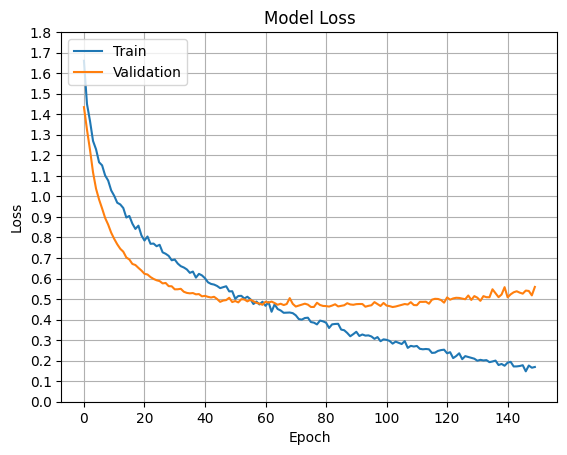

In [ ]:
metrics_table(history6_1)
acc_loss_plot(history6_1)

In [ ]:
# Saving the history
with open('history6_1.pkl', 'wb') as f:
    pickle.dump(history6_1.history, f)

# save model weight and architecture to single file
model6_1.save("model6_1.h5")

6/6 [==============================] - 1s 108ms/step


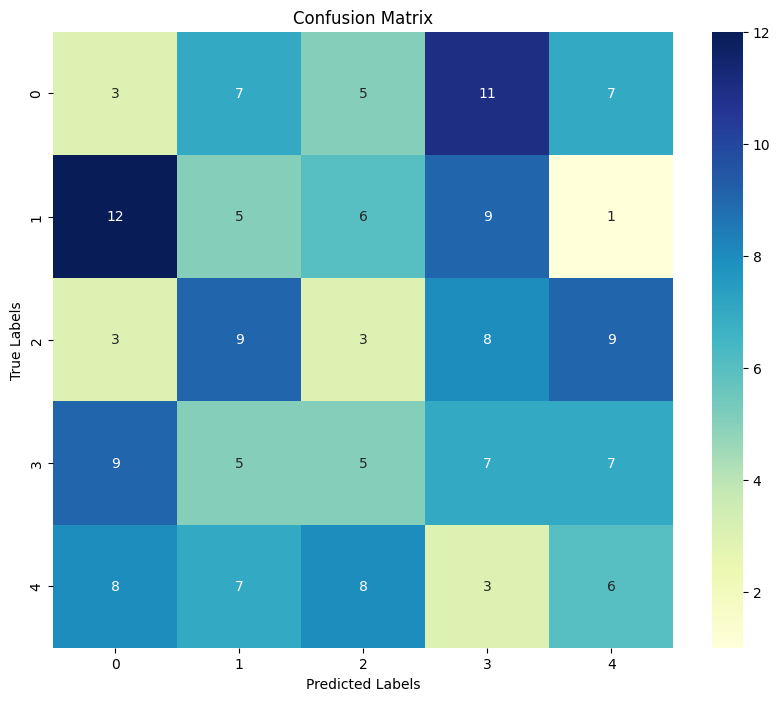

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the predictions and true labels
y_pred = model6_1.predict(val_generator)
y_true = val_generator.classes

# Convert the predictions and true labels to integers
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(y_true)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## retrain 2

In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model50.output)
dense1 = tf.keras.layers.Dense(32, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model6_2 = tf.keras.Model(base_model50.input, prediction)

loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model6_2.compile(loss = loss, optimizer = opt, metrics = metric)

history6_2 = model6_2.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 11s 140ms/step - loss: 1.6315 - categorical_accuracy: 0.2609 - precision_2: 0.4485 - recall_2: 0.0468 - val_loss: 1.3786 - val_categorical_accuracy: 0.4601 - val_precision_2: 1.0000 - val_recall_2: 0.0245
Epoch 2/150
41/41 [==============================] - 3s 68ms/step - loss: 1.4347 - categorical_accuracy: 0.3269 - precision_2: 0.6480 - recall_2: 0.0975 - val_loss: 1.2506 - val_categorical_accuracy: 0.5153 - val_precision_2: 1.0000 - val_recall_2: 0.0859
Epoch 3/150
41/41 [==============================] - 3s 74ms/step - loss: 1.3136 - categorical_accuracy: 0.4198 - precision_2: 0.7209 - recall_2: 0.1427 - val_loss: 1.1394 - val_categorical_accuracy: 0.6196 - val_precision_2: 0.8889 - val_recall_2: 0.1963
Epoch 4/150
41/41 [==============================] - 3s 68ms/step - loss: 1.2646 - categorical_accuracy: 0.4421 - precision_2: 0.6492 - recall_2: 0.1903 - val_loss: 1.0438 - val_categorical_accuracy: 0.6564 - val_precision_2: 0.90

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.950115 | 0.809816 |
+-----------+----------+----------+
| Loss      | 0.169088 | 0.488644 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.94551  | 0.779141 |
+-----------+----------+----------+
| Loss      | 0.169088 | 0.595407 |
+-----------+----------+----------+


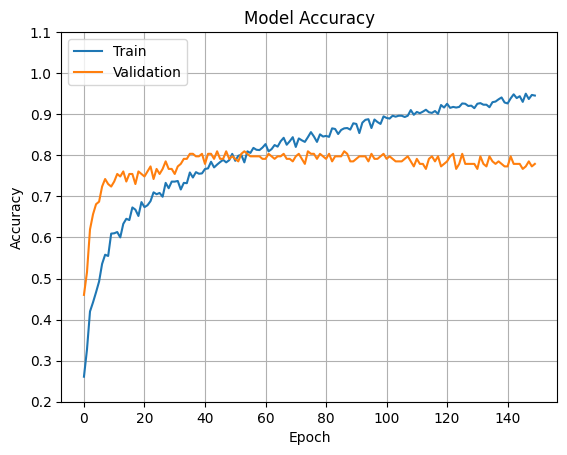

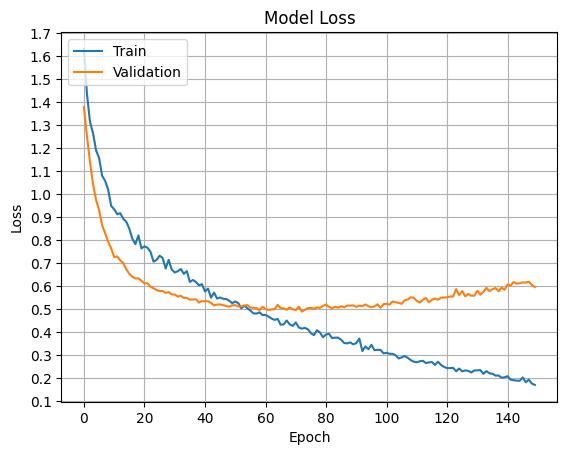

In [ ]:
metrics_table(history6_2)
acc_loss_plot(history6_2)

## retrain 3

In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model50.output)
dense1 = tf.keras.layers.Dense(32, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model6_3 = tf.keras.Model(base_model50.input, prediction)

loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model6_3.compile(loss = loss, optimizer = opt, metrics = metric)

history6_3 = model6_3.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 9s 114ms/step - loss: 1.6903 - categorical_accuracy: 0.2072 - precision_3: 0.2838 - recall_3: 0.0161 - val_loss: 1.5555 - val_categorical_accuracy: 0.3313 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/150
41/41 [==============================] - 3s 66ms/step - loss: 1.5272 - categorical_accuracy: 0.3039 - precision_3: 0.5663 - recall_3: 0.0361 - val_loss: 1.4254 - val_categorical_accuracy: 0.4294 - val_precision_3: 1.0000 - val_recall_3: 0.0184
Epoch 3/150
41/41 [==============================] - 3s 74ms/step - loss: 1.4350 - categorical_accuracy: 0.3576 - precision_3: 0.6029 - recall_3: 0.0629 - val_loss: 1.3262 - val_categorical_accuracy: 0.5031 - val_precision_3: 0.8889 - val_recall_3: 0.0491
Epoch 4/150
41/41 [==============================] - 3s 68ms/step - loss: 1.3767 - categorical_accuracy: 0.3975 - precision_3: 0.6188 - recall_3: 0.0860 - val_loss: 1.2369 - val_categorical_accuracy: 0.5583 - val_precision_

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.95165  | 0.803681 |
+-----------+----------+----------+
| Loss      | 0.157624 | 0.492475 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.95165  | 0.785276 |
+-----------+----------+----------+
| Loss      | 0.157624 | 0.606838 |
+-----------+----------+----------+


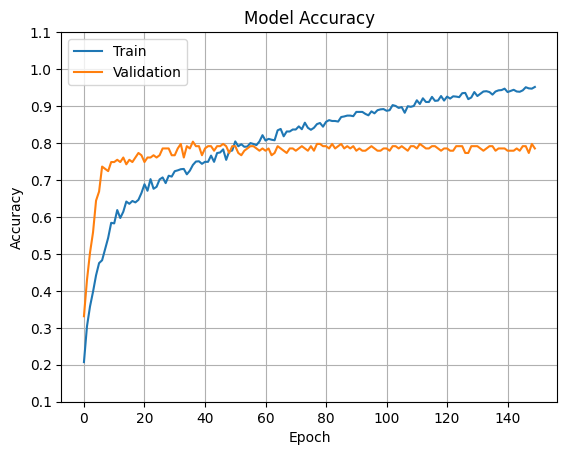

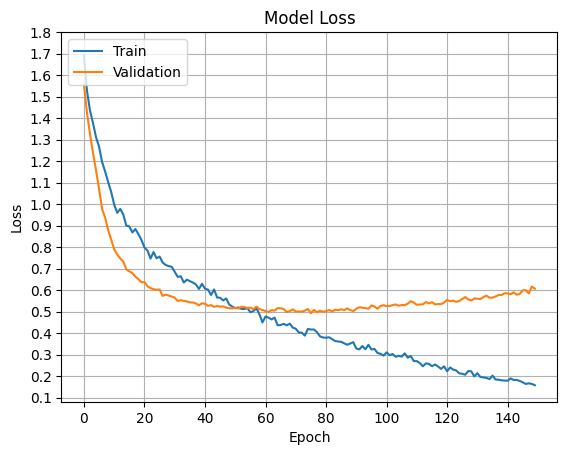

In [ ]:
metrics_table(history6_3)
acc_loss_plot(history6_3)

## Retrain 4

In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model50.output)
dense1 = tf.keras.layers.Dense(32, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model6_4 = tf.keras.Model(base_model50.input, prediction)

loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model6_4.compile(loss = loss, optimizer = opt, metrics = metric)

history6_4 = model6_4.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 9s 115ms/step - loss: 1.6448 - categorical_accuracy: 0.2433 - precision_4: 0.1667 - recall_4: 0.0054 - val_loss: 1.4924 - val_categorical_accuracy: 0.4663 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/150
41/41 [==============================] - 3s 68ms/step - loss: 1.4860 - categorical_accuracy: 0.3523 - precision_4: 0.5000 - recall_4: 0.0230 - val_loss: 1.3656 - val_categorical_accuracy: 0.5890 - val_precision_4: 0.5000 - val_recall_4: 0.0061
Epoch 3/150
41/41 [==============================] - 3s 77ms/step - loss: 1.3980 - categorical_accuracy: 0.4045 - precision_4: 0.6259 - recall_4: 0.0706 - val_loss: 1.2459 - val_categorical_accuracy: 0.6196 - val_precision_4: 0.8333 - val_recall_4: 0.0307
Epoch 4/150
41/41 [==============================] - 3s 72ms/step - loss: 1.3515 - categorical_accuracy: 0.4037 - precision_4: 0.6245 - recall_4: 0.1251 - val_loss: 1.1878 - val_categorical_accuracy: 0.6319 - val_precision_

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.956255 | 0.815951 |
+-----------+----------+----------+
| Loss      | 0.15648  | 0.492484 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.956255 | 0.791411 |
+-----------+----------+----------+
| Loss      | 0.162337 | 0.654403 |
+-----------+----------+----------+


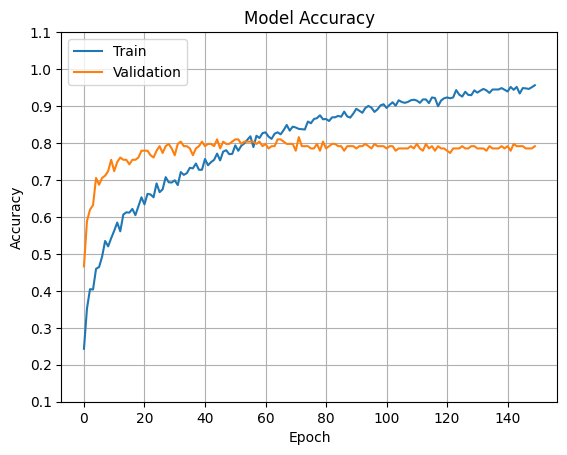

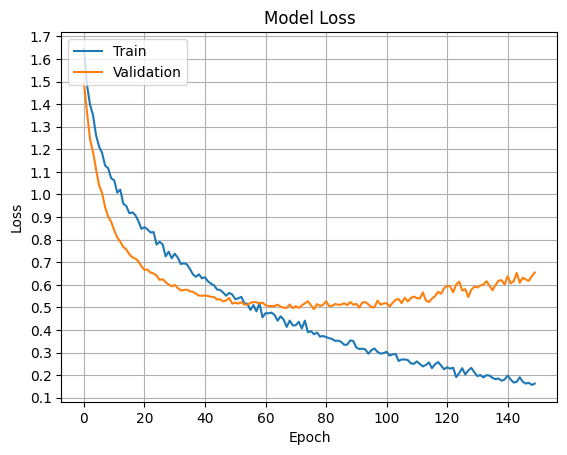

In [ ]:
metrics_table(history6_4)
acc_loss_plot(history6_4)

## retrain 5


In [ ]:
flatten = tf.keras.layers.GlobalAveragePooling2D()(base_model50.output)
dense1 = tf.keras.layers.Dense(32, activation = "relu")(flatten)
reg1 = tf.keras.layers.Dropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(reg1)
reg2 = tf.keras.layers.Dropout(0.5)(dense2)
prediction = tf.keras.layers.Dense(5, activation = "softmax", name = "prediction")(reg2)
model6_5 = tf.keras.Model(base_model50.input, prediction)

loss = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-4)
metric = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model6_5.compile(loss = loss, optimizer = opt, metrics = metric)

history6_5 = model6_5.fit(train_generator, epochs=150, validation_data=val_generator)

Epoch 1/150
41/41 [==============================] - 9s 109ms/step - loss: 1.5885 - categorical_accuracy: 0.2893 - precision_5: 0.4667 - recall_5: 0.0483 - val_loss: 1.3398 - val_categorical_accuracy: 0.5951 - val_precision_5: 0.6667 - val_recall_5: 0.0245
Epoch 2/150
41/41 [==============================] - 3s 69ms/step - loss: 1.3762 - categorical_accuracy: 0.4198 - precision_5: 0.6276 - recall_5: 0.1151 - val_loss: 1.1880 - val_categorical_accuracy: 0.6074 - val_precision_5: 0.8696 - val_recall_5: 0.1227
Epoch 3/150
41/41 [==============================] - 3s 73ms/step - loss: 1.2527 - categorical_accuracy: 0.4666 - precision_5: 0.6563 - recall_5: 0.1788 - val_loss: 1.0616 - val_categorical_accuracy: 0.6442 - val_precision_5: 0.8605 - val_recall_5: 0.2270
Epoch 4/150
41/41 [==============================] - 3s 69ms/step - loss: 1.1971 - categorical_accuracy: 0.4866 - precision_5: 0.6598 - recall_5: 0.2441 - val_loss: 0.9896 - val_categorical_accuracy: 0.6748 - val_precision_5: 0.836

Best Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.95779  | 0.815951 |
+-----------+----------+----------+
| Loss      | 0.155325 | 0.511816 |
+-----------+----------+----------+

Last Metrics
+-----------+----------+----------+
| Metrics   |    Train |      Val |
+===========+==========+==========+
| Accuracy  | 0.946278 | 0.791411 |
+-----------+----------+----------+
| Loss      | 0.164268 | 0.645305 |
+-----------+----------+----------+


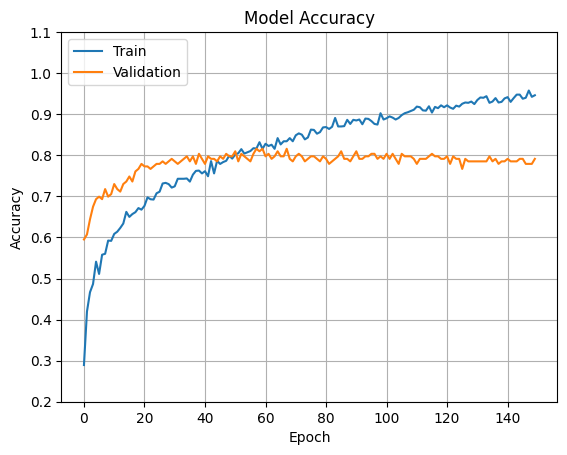

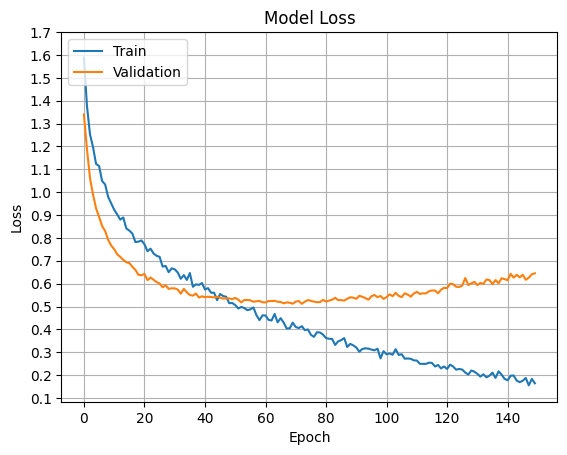

In [ ]:
metrics_table(history6_5)
acc_loss_plot(history6_5)